In [1]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_smooth/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset



In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [3]:
#locations
location_index = np.zeros(846*12)
location_month_index= np.zeros(846*12)


for i in range(12):
    for j in range(846):
        location_index[i*846+j] = i
        location_month_index[i*846+j] = np.floor(j/60)


In [4]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [5]:
PATH_LIST_full

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/08_kuroshio_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/06_california_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [126]:
label_list = ['Arabian Sea','Agulhas Current', 'New Zealand', 'Kuroshio Current', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific', 'California Current','Indian Ocean' ]

# prediction and target by location

## Resolution R^2

In [145]:
#r2_summer_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_summer_loc_v3.npy')
#r2_winter_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_winter_loc_v3.npy')
r2_summer_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn_summer_loc.npy')
r2_winter_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn_winter_loc.npy')
#r2_param_summer_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_param_summer_loc.npy')
#r2_param_winter_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_param_winter_loc.npy')
r2_m_loc_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_m_loc_loc_v3.npy')
#r2_cnn_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn_loc_v2.npy')

In [146]:
# sort by latitude

lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0

for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]


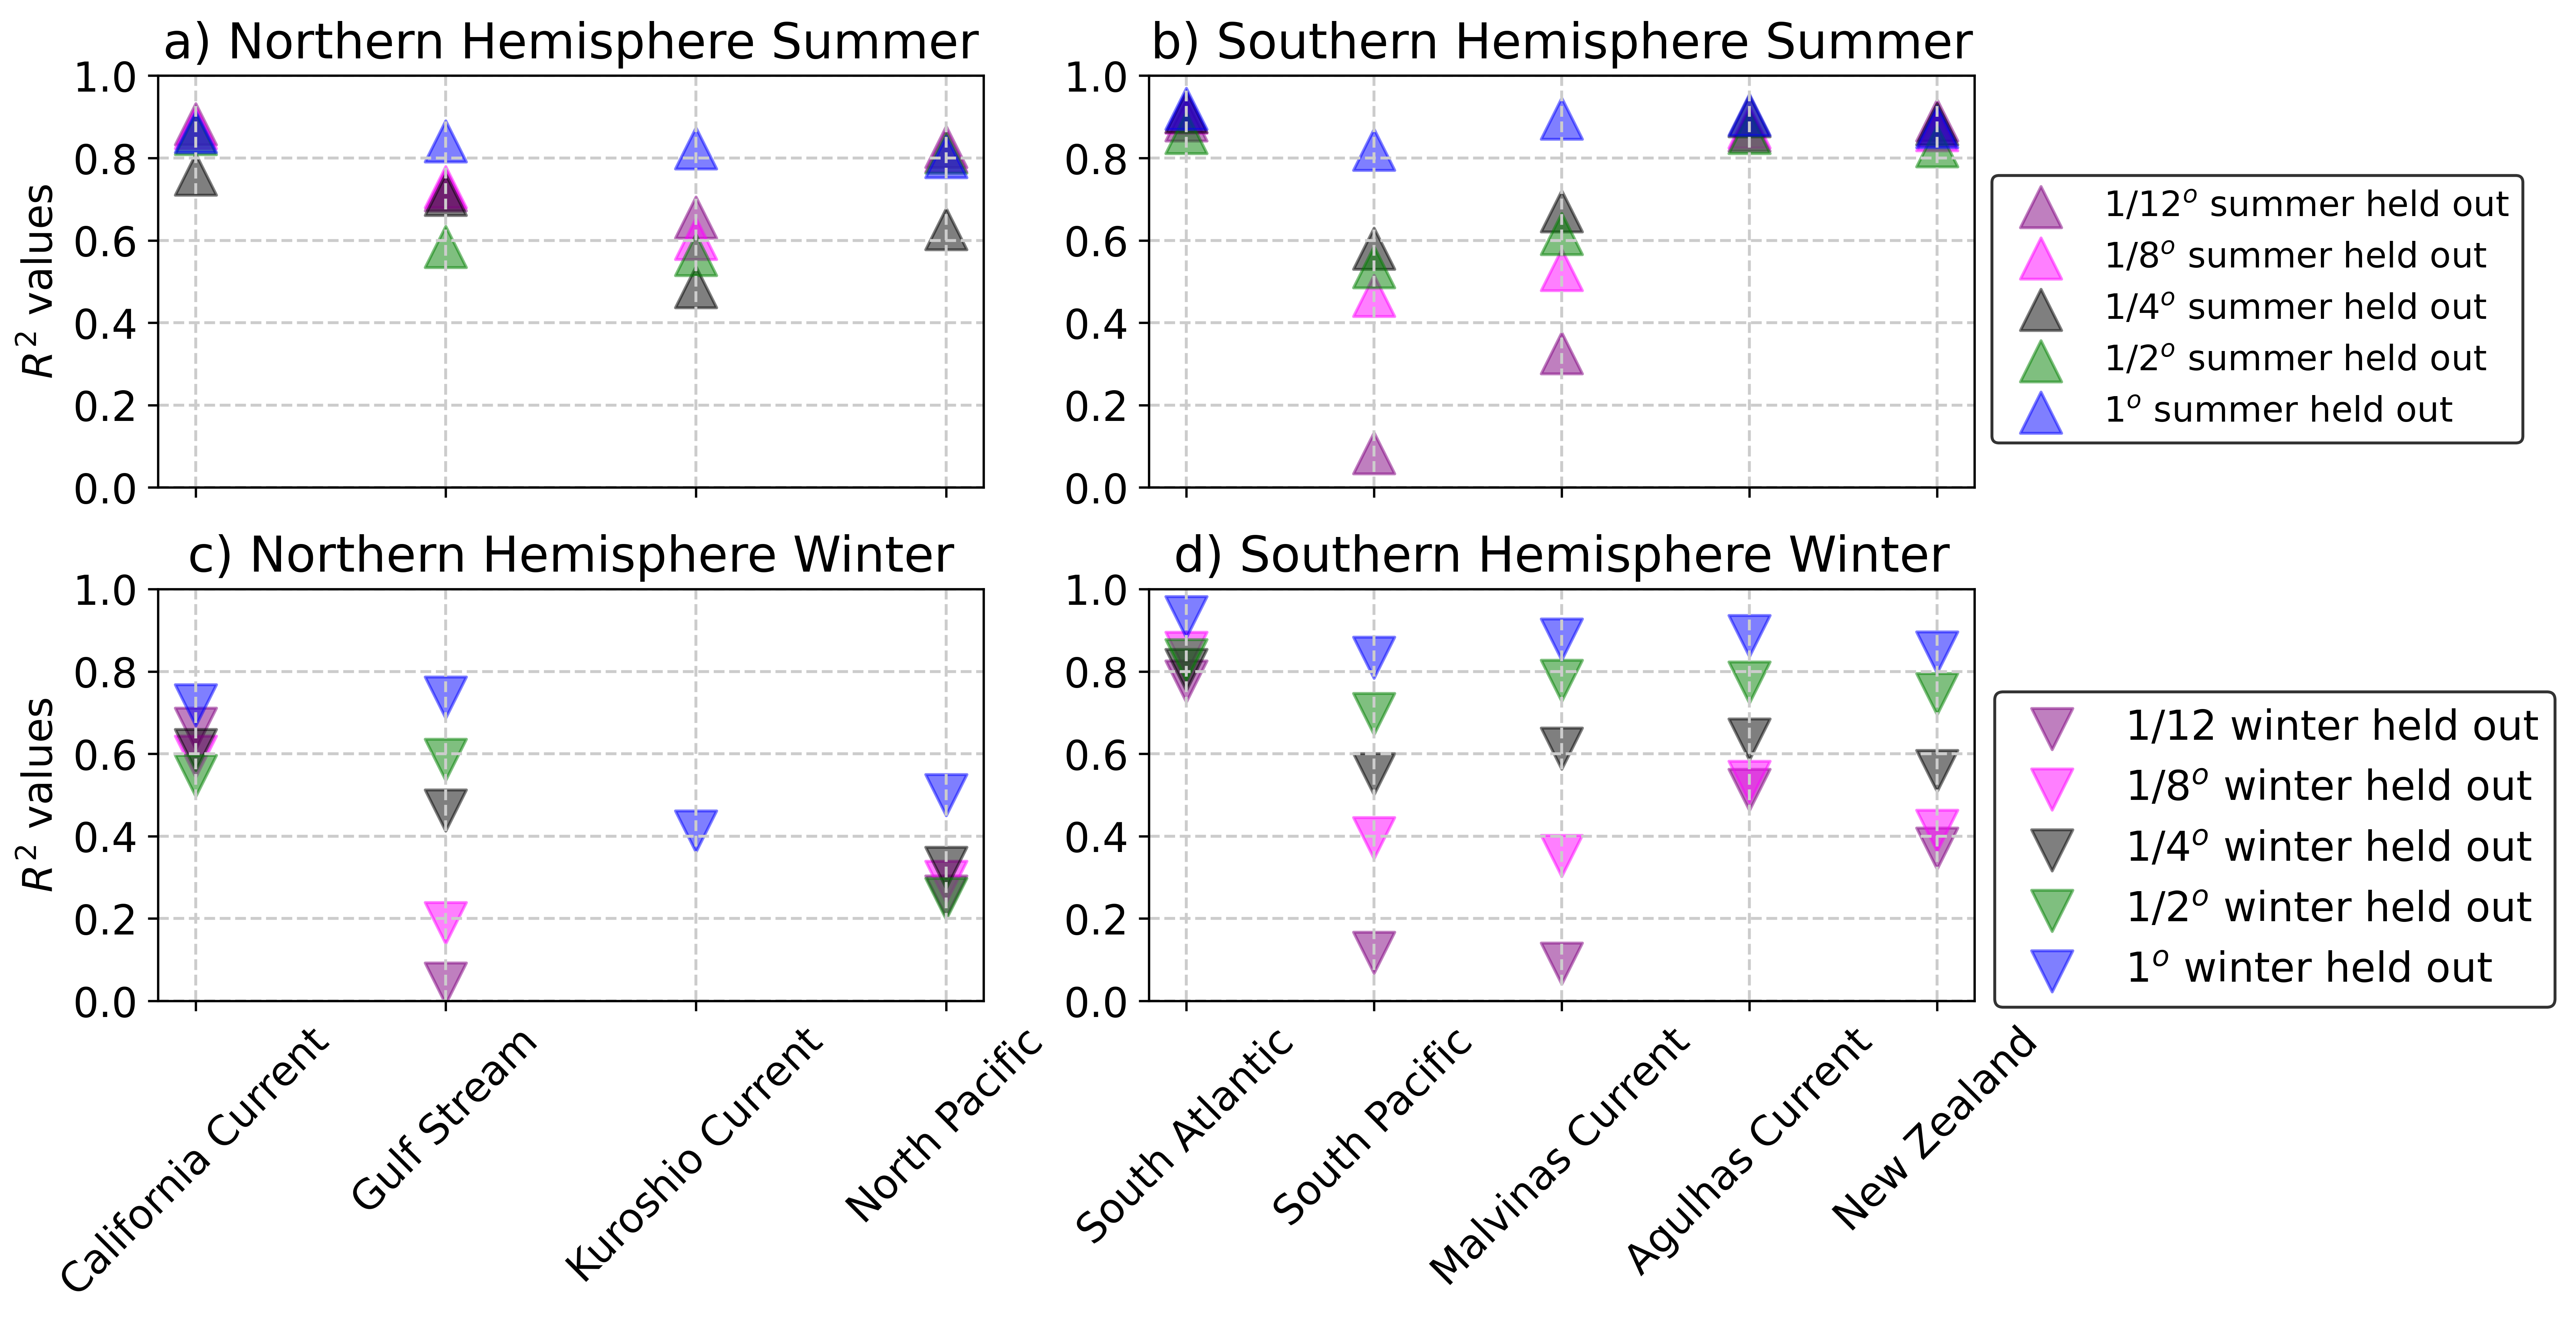

In [147]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8),dpi=600)
fig.tight_layout(pad=2.0)
plt.rcParams.update({'font.size': 14})

plt.subplot(3,2,1)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12)[:4],r2_summer_loc[0,lat_ind_sorted[:4]],s=200,marker='^',color= 'purple', alpha=0.5,label='$1/12^o$ summer held out')
#plt.scatter(range(12)[:4],r2_cnn_summer_loc[0,lat_ind_sorted[:4]],s=200,marker='o',color= 'purple', alpha=0.5,label='1/12 summer held out')

plt.scatter(range(12)[:4],r2_summer_loc[1,lat_ind_sorted][:4],s=200,marker='^',color='magenta',alpha=0.5,label='$1/8^o$ summer held out')
#plt.scatter(range(12)[:4],r2_cnn_summer_loc[1,lat_ind_sorted][:4],s=200,marker='o',color='magenta',alpha=0.5,label='1/8 summer held out')

plt.scatter(range(12)[:4],r2_summer_loc[2,lat_ind_sorted][:4],s=200,marker='^',color='k',alpha=0.5,label='$1/4^o$ summer held out')
#plt.scatter(range(12)[:4],r2_cnn_summer_loc[2,lat_ind_sorted][:4],s=200,marker='o',color='k',alpha=0.5,label='1/8 summer held out')

plt.scatter(range(12)[:4],r2_summer_loc[3,lat_ind_sorted][:4],s=200,marker='^',color='green',alpha=0.5,label='$1/2^o$ summer held out')
#plt.scatter(range(12)[:4],r2_cnn_summer_loc[3,lat_ind_sorted][:4],s=200,marker='o',color='green',alpha=0.5,label='1/2 summer held out')

plt.scatter(range(12)[:4],r2_summer_loc[4,lat_ind_sorted][:4],s=200,marker='^',color='blue',alpha=0.5,label='$1^o$ summer held out')
#plt.scatter(range(12)[:4],r2_cnn_summer_loc[4,lat_ind_sorted][:4],s=200,marker='o',color='blue',alpha=0.5,label='1 summer held out')
plt.title('a) Northern Hemisphere Summer')
#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
plt.xticks(np.arange(len(label_list))[:4], [],rotation = 45, fontsize=14);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#/plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')



plt.subplot(3,2,2)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12)[7:],r2_summer_loc[0,lat_ind_sorted[7:]],s=200,marker='^',color= 'purple', alpha=0.5,label='$1/12^o$ summer held out')

plt.scatter(range(12)[7:],r2_summer_loc[1,lat_ind_sorted][7:],s=200,marker='^',color='magenta',alpha=0.5,label='$1/8^o$ summer held out')
#plt.scatter(range(12),r2_winter_loc[1,lat_ind_sorted],s=200,marker='v',color='magenta',alpha=0.5,label='1/8 winter held out')
#plt.scatter(range(12),r2_cnn_loc[1,lat_ind_sorted],s=200,c= 'magenta',marker='*',alpha=0.5,label='$1/8^o$ CNN')

plt.scatter(range(12)[7:],r2_summer_loc[2,lat_ind_sorted][7:],s=200,marker='^',color='k',alpha=0.5,label='$1/4^o$ summer held out')
#plt.scatter(range(12),r2_winter_loc[2,lat_ind_sorted],s=200,marker='v',color='k',alpha=0.5,label='1/4 winter held out')
#plt.scatter(range(12),r2_cnn_loc[2,lat_ind_sorted],s=200,c= 'k',marker='*',alpha=0.5,label='$1/4^o$ CNN')

plt.scatter(range(12)[7:],r2_summer_loc[3,lat_ind_sorted][7:],s=200,marker='^',color='green',alpha=0.5,label='$1/2^o$ summer held out')
#plt.scatter(range(12),r2_winter_loc[3,lat_ind_sorted],s=200,marker='v',color='green',alpha=0.5,label='1/2 winter held out')
#plt.scatter(range(12),r2_cnn_loc[3,lat_ind_sorted],s=200,c= 'green',marker='*',alpha=0.5,label='$1/2^o$ CNN')

plt.scatter(range(12)[7:],r2_summer_loc[4,lat_ind_sorted][7:],s=200,marker='^',color='blue',alpha=0.5,label='$1^o$ summer held out')
#plt.scatter(range(12),r2_winter_loc[4,lat_ind_sorted],s=200,marker='v',color='blue',alpha=0.5,label='1 winter held out')
#plt.scatter(range(12),r2_cnn_loc[4,lat_ind_sorted],s=200,c= 'blue',marker='*',alpha=0.5,label='$1^o$ CNN')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(np.arange(len(label_list))[7:], [],rotation = 45, fontsize=14);
#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=12,bbox_to_anchor=(1., 0.8),ncol=1).get_frame().set_edgecolor('k')
plt.title('b) Southern Hemisphere Summer')

plt.subplot(3,2,3)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12)[:4],r2_winter_loc[0,lat_ind_sorted[:4]],s=200,marker='v',color= 'purple', alpha=0.5,label='$1/12^o$ winter held out')
#plt.scatter(range(12)[:4],r2_cnn_winter_loc[0,lat_ind_sorted[:4]],s=200,marker='o',color= 'purple', alpha=0.5,label='1/12 winter held out')

plt.scatter(range(12)[:4],r2_winter_loc[1,lat_ind_sorted][:4],s=200,marker='v',color='magenta',alpha=0.5,label='$1/8^o$ winter held out')
#plt.scatter(range(12)[:4],r2_cnn_winter_loc[1,lat_ind_sorted[:4]],s=200,marker='o',color= 'magenta', alpha=0.5,label='1/8 winter held out')

plt.scatter(range(12)[:4],r2_winter_loc[2,lat_ind_sorted][:4],s=200,marker='v',color='k',alpha=0.5,label='$1/4^o$ winter held out')
#plt.scatter(range(12)[:4],r2_cnn_winter_loc[2,lat_ind_sorted[:4]],s=200,marker='o',color= 'k', alpha=0.5,label='1/4 winter held out')

plt.scatter(range(12)[:4],r2_winter_loc[3,lat_ind_sorted][:4],s=200,marker='v',color='green',alpha=0.5,label='$1/2^o$ winter held out')
#plt.scatter(range(12)[:4],r2_cnn_winter_loc[3,lat_ind_sorted[:4]],s=200,marker='o',color= 'green', alpha=0.5,label='1/2 winter held out')

plt.scatter(range(12)[:4],r2_winter_loc[4,lat_ind_sorted][:4],s=200,marker='v',color='blue',alpha=0.5,label='$1^o$ winter held out')
#plt.scatter(range(12)[:4],r2_cnn_winter_loc[4,lat_ind_sorted[:4]],s=200,marker='o',color= 'blue', alpha=0.5,label='1 winter held out')

my_xticks = [label_list[i] for i in lat_ind_sorted[:4]] 
#plt.xticks([]);
plt.xticks(np.arange(len(label_list))[:4], my_xticks, rotation = 45, fontsize=14);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')
plt.title('c) Northern Hemisphere Winter')


plt.subplot(3,2,4)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12)[7:],r2_winter_loc[0,lat_ind_sorted[7:]],s=200,marker='v',color= 'purple', alpha=0.5,label='1/12 winter held out')
#plt.scatter(range(12)[7:],r2_cnn_winter_loc[0,lat_ind_sorted[7:]],s=200,marker='o',color= 'purple', alpha=0.5,label='$1/12^o$ winter held out')

plt.scatter(range(12)[7:],r2_winter_loc[1,lat_ind_sorted][7:],s=200,marker='v',color='magenta',alpha=0.5,label='$1/8^o$ winter held out')
#plt.scatter(range(12)[7:],r2_cnn_winter_loc[1,lat_ind_sorted[7:]],s=200,marker='o',color= 'magenta', alpha=0.5,label='1/8 winter held out')

plt.scatter(range(12)[7:],r2_winter_loc[2,lat_ind_sorted][7:],s=200,marker='v',color='k',alpha=0.5,label='$1/4^o$ winter held out')
#plt.scatter(range(12)[7:],r2_cnn_winter_loc[2,lat_ind_sorted[7:]],s=200,marker='o',color= 'k', alpha=0.5,label='1/4 winter held out')

plt.scatter(range(12)[7:],r2_winter_loc[3,lat_ind_sorted][7:],s=200,marker='v',color='green',alpha=0.5,label='$1/2^o$ winter held out')
#plt.scatter(range(12)[7:],r2_cnn_winter_loc[3,lat_ind_sorted[7:]],s=200,marker='o',color= 'green', alpha=0.5,label='1/2 winter held out')

plt.scatter(range(12)[7:],r2_winter_loc[4,lat_ind_sorted][7:],s=200,marker='v',color='blue',alpha=0.5,label='$1^o$ winter held out')
#plt.scatter(range(12)[7:],r2_cnn_winter_loc[4,lat_ind_sorted[7:]],s=200,marker='o',color= 'blue', alpha=0.5,label='1 winter held out')
plt.title('d) Southern Hemisphere Winter')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted][7:]
plt.xticks(np.arange(len(label_list))[7:], my_xticks,rotation = 45, fontsize=14);

#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 0.8),ncol=1).get_frame().set_edgecolor('k')
#plt.savefig('./figures/r2_sensitivity_seasons_split',bbox_inches = 'tight')




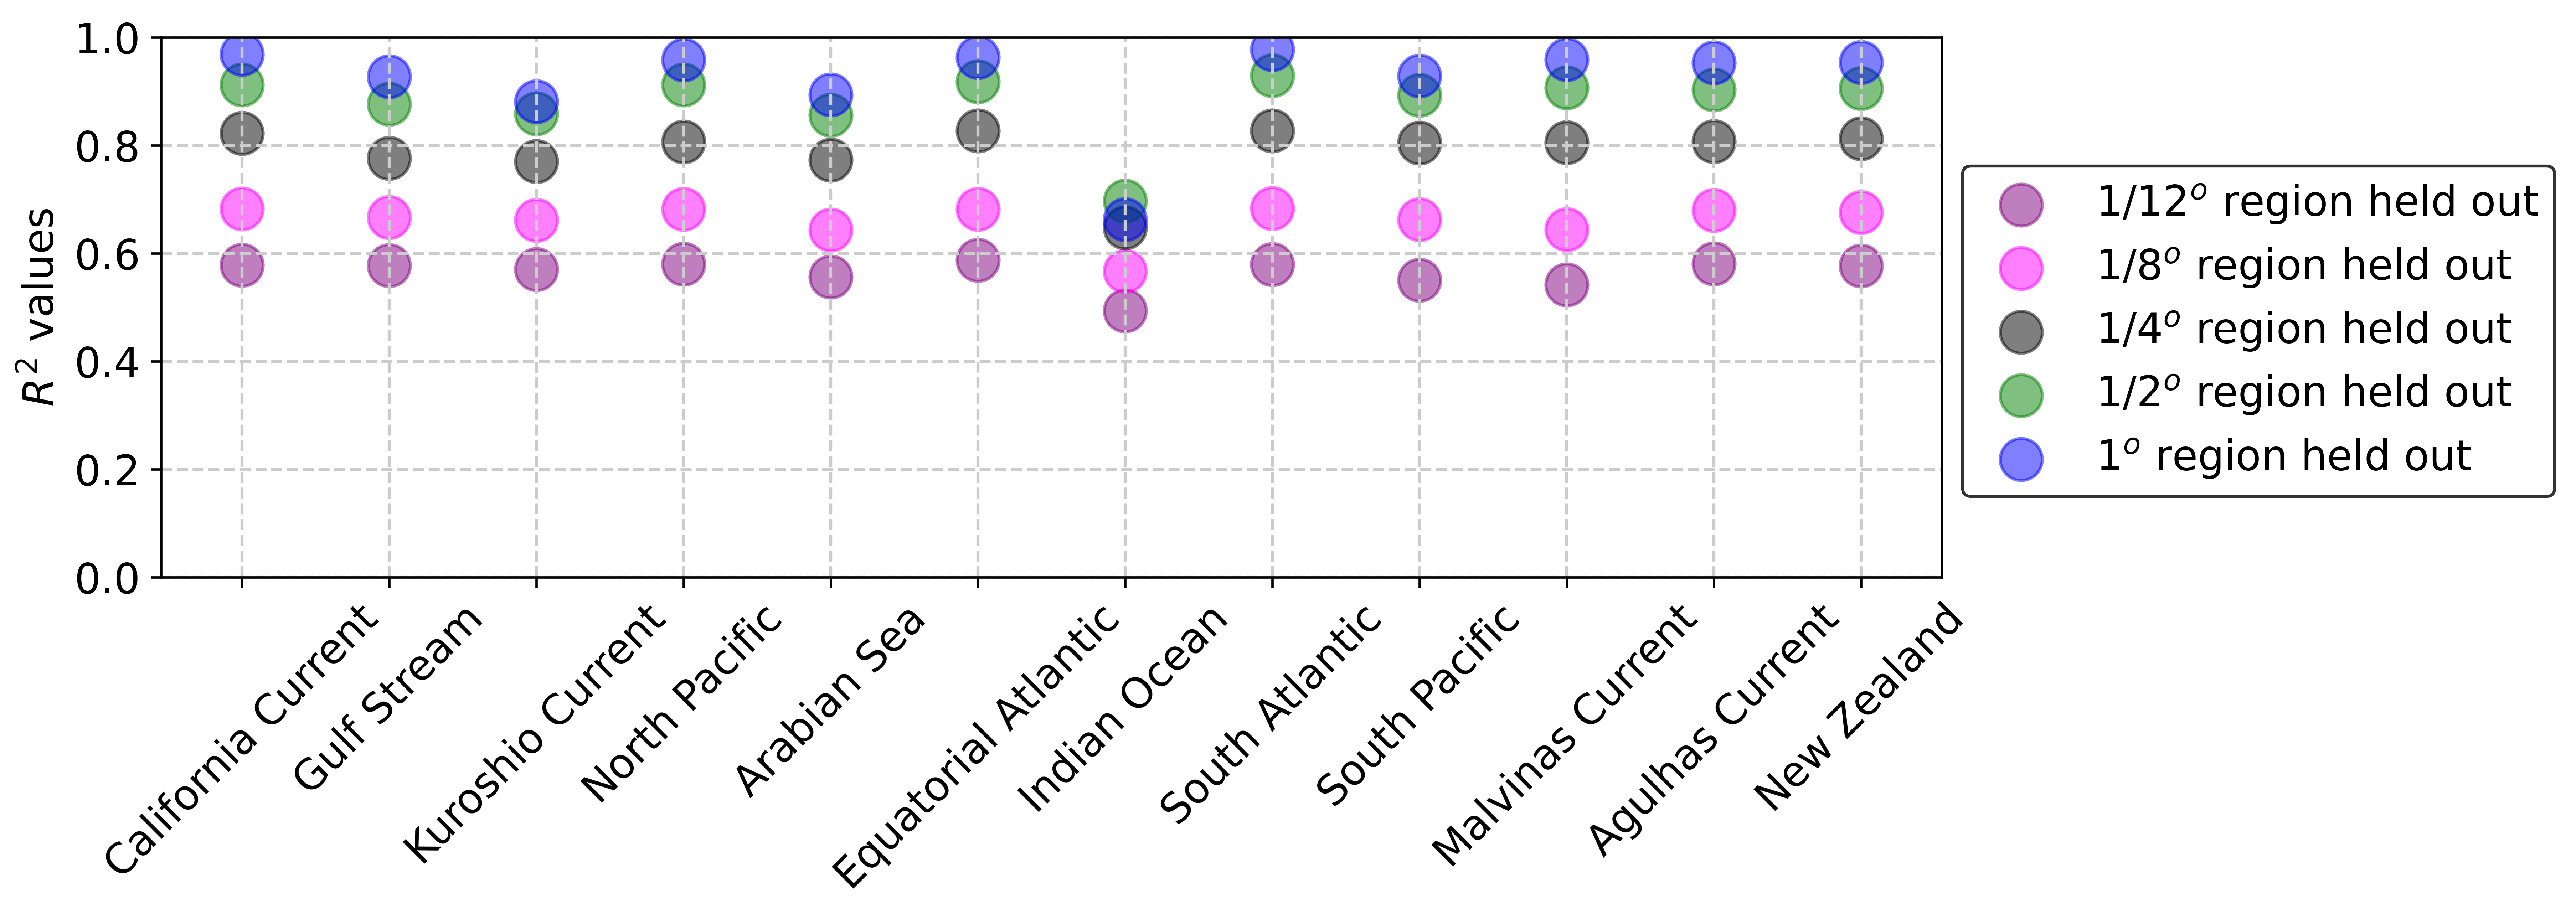

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12,6),dpi=600)
fig.tight_layout(pad=8.0)
plt.rcParams.update({'font.size': 14})
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12),r2_m_loc_loc[0,lat_ind_sorted],s=200,marker='o',color= 'purple',alpha=0.5, label='$1/12^o$ region held out')
#plt.scatter(range(12),r2_m_loc_loc[0,lat_ind_sorted],s=200,c= 'purple',marker='X',alpha=0.5,label='$1/12^o$ region held out')

plt.scatter(range(12),r2_m_loc_loc[1,lat_ind_sorted],s=200,marker='o',color='magenta',alpha=0.5,label='$1/8^o$ region held out')
#plt.scatter(range(12),r2_m_loc_loc[1,lat_ind_sorted],s=200,c= 'magenta',marker='X',alpha=0.5,label='$1/8^o$ region held out')

plt.scatter(range(12),r2_m_loc_loc[2,lat_ind_sorted],s=200,marker='o',color='k',alpha=0.5,label='$1/4^o$ region held out')
#plt.scatter(range(12),r2_m_loc_loc[2,lat_ind_sorted],s=200,c= 'k',marker='X',alpha=0.5,label='$1/4^o$ region held out')

plt.scatter(range(12),r2_m_loc_loc[3,lat_ind_sorted],s=200,marker='o',color='green',alpha=0.5,label='$1/2^o$ region held out')
#plt.scatter(range(12),r2_m_loc_loc[3,lat_ind_sorted],s=200,c= 'green',marker='X',alpha=0.5,label='$1/2^o$ region held out')

plt.scatter(range(12),r2_m_loc_loc[4,lat_ind_sorted],s=200,marker='o',color='blue',alpha=0.5,label='$1^o$ region held out')
#plt.scatter(range(12),r2_m_loc_loc[4,lat_ind_sorted],s=200,c= 'blue',marker='X',alpha=0.5,label='$1^o$ region held out')


my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(np.arange(len(label_list)), my_xticks,rotation = 45,fontsize=14);
#plt.xticks(np.arange(len(label_list)), label_list,rotation = 45, fontsize=12);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(0.06, 1),ncol=5).get_frame().set_edgecolor('k')
plt.legend(fontsize=14,bbox_to_anchor=(1.0, .8),ncol=1).get_frame().set_edgecolor('k')

#plt.savefig('./figures/r2_sensitivity_loc_split',bbox_inches = 'tight')

In [11]:
r2_cnn_param_summer = np.zeros((5,24))
r2_cnn_param_summer[:,::2] = r2_cnn_summer_loc[:,lat_ind_sorted]
r2_cnn_param_summer[:,1::2] = r2_param_summer_loc[:,lat_ind_sorted]

r2_cnn_param_winter = np.zeros((5,24))
r2_cnn_param_winter[:,::2] = r2_cnn_winter_loc[:,lat_ind_sorted]
r2_cnn_param_winter[:,1::2] = r2_param_winter_loc[:,lat_ind_sorted]

In [12]:
r2_cnn_param_summer[0,::2][:4]

array([0.88218317, 0.72197983, 0.65603346, 0.82695264])

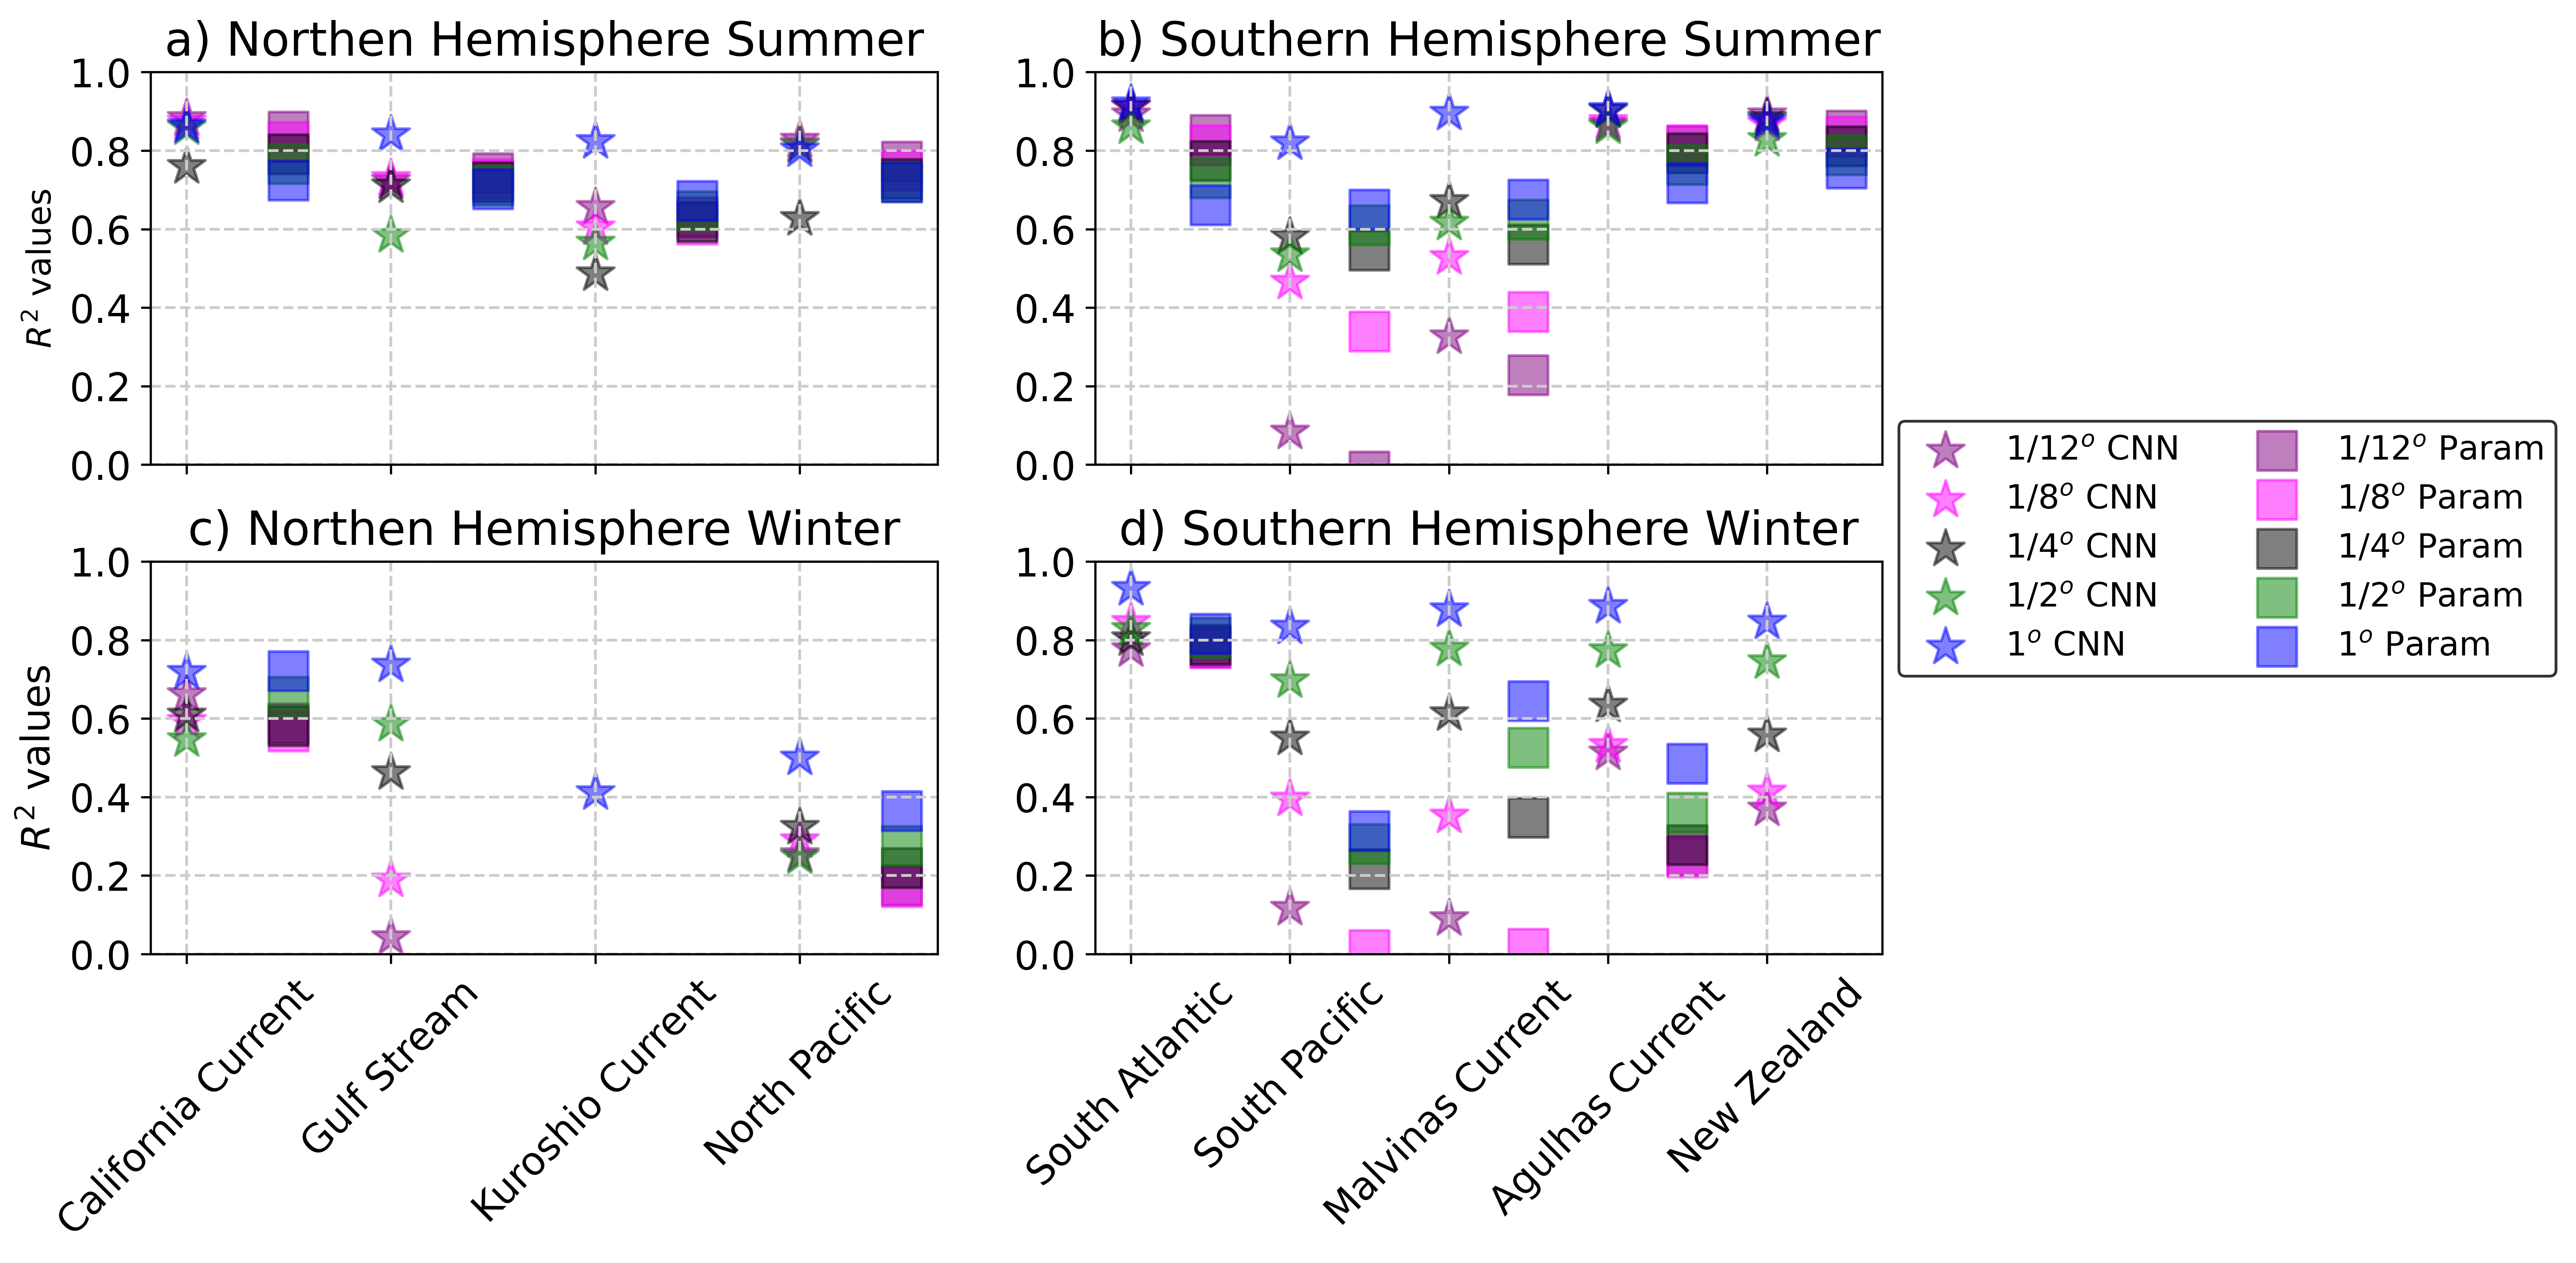

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8),dpi=600)
fig.tight_layout(pad=2.0)
plt.rcParams.update({'font.size': 14})

plt.subplot(3,2,1)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[0,::2][:4],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[0,1::2][:4],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[1,::2][:4],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[1,1::2][:4],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')


plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[2,::2][:4],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[2,1::2][:4],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[3,::2][:4],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[3,1::2][:4],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[4,::2][:4],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[4,1::2][:4],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('a) Northen Hemisphere Summer')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
plt.xticks(range(24)[::2][:4], [],rotation = 45, fontsize=12);
plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
#/plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')



plt.subplot(3,2,2)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[0,::2][7:],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[1,::2][7:],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[2,::2][7:],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[3,::2][7:],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[4,::2][7:],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')

plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[0,1::2][7:],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[1,1::2][7:],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[2,1::2][7:],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[3,1::2][7:],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[4,1::2][7:],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('b) Southern Hemisphere Summer')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(range(24)[::2][7:], [],rotation = 45, fontsize=14);
#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(1., 0.8),ncol=2).get_frame().set_edgecolor('k')


plt.subplot(3,2,3)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[0,::2][:4],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[0,1::2][:4],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[1,::2][:4],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[1,1::2][:4],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')


plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[2,::2][:4],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[2,1::2][:4],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[3,::2][:4],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[3,1::2][:4],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[4,::2][:4],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[4,1::2][:4],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('c) Northen Hemisphere Winter')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
plt.xticks(range(24)[::2][:4], my_xticks[:4],rotation = 45, fontsize=14);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')



plt.subplot(3,2,4)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[0,::2][7:],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[1,::2][7:],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[2,::2][7:],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[3,::2][7:],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[4,::2][7:],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')

plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[0,1::2][7:],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[1,1::2][7:],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[2,1::2][7:],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[3,1::2][7:],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[4,1::2][7:],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('d) Southern Hemisphere Winter')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(range(24)[::2][7:], my_xticks[7:],rotation = 45, fontsize=14);

#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=12,bbox_to_anchor=(1.0, 1.4),ncol=2).get_frame().set_edgecolor('k')
plt.savefig('./figures/r2_cnn_seasons',bbox_inches = 'tight')




In [93]:
#!/usr/bin/env python
# coding: utf-8

import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_smooth/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset


# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

    
    
    
res_strg = ['1_12','1_8','1_4','1_2','1']


r2_winter_monthly_mean = np.empty((5,12,12))
r2_winter_monthly_mean[:] = np.nan
r2_summer_monthly_mean = np.empty((5,12,12))
r2_summer_monthly_mean[:] = np.nan
r2_m_loc_monthly_mean = np.empty((5,12,12))
r2_m_loc_monthly_mean[:] = np.nan


for i_res in range(1):
    i_res = 4
    
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR',  'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res=res_strg[i_res])

    test_loader_winter=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_winter_ind),
        sampler=submeso_dataset.test_winter_ind)

    test_loader_summer=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_summer_ind),
        sampler=submeso_dataset.test_summer_ind)

    test_loader=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)

    

        # data loader loc 0
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=0, res=res_strg[i_res])

    test_loader_loc_0=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 1
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=1, res=res_strg[i_res])

    test_loader_loc_1=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 2
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=2, res=res_strg[i_res])

    test_loader_loc_2=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 3
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=3, res=res_strg[i_res])

    test_loader_loc_3=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 4
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=4, res=res_strg[i_res])

    test_loader_loc_4=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)



    # data loader loc 5
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=5, res=res_strg[i_res])

    test_loader_loc_5=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 6
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=6, res=res_strg[i_res])

    test_loader_loc_6=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 7
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=7, res=res_strg[i_res])

    test_loader_loc_7=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)



    # data loader loc 8
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=8, res=res_strg[i_res])

    test_loader_loc_8=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 9
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=9, res=res_strg[i_res])

    test_loader_loc_9=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)



    # data loader loc 10
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=10, res=res_strg[i_res])

    test_loader_loc_10=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)


    # data loader loc 11
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
                  'Q', 'HBL', 'div', 'vort', 'strain'], loc_num=11, res=res_strg[i_res])

    test_loader_loc_11=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)



    # load trained models
    model_loc_0 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_0_res_'+res_strg[i_res]+'.pt')
    model_loc_1 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_1_res_'+res_strg[i_res]+'.pt')
    model_loc_2 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_2_res_'+res_strg[i_res]+'.pt')
    model_loc_3 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_3_res_'+res_strg[i_res]+'.pt')
    model_loc_4 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_4_res_'+res_strg[i_res]+'.pt')
    model_loc_5 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_5_res_'+res_strg[i_res]+'.pt')
    model_loc_6 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_6_res_'+res_strg[i_res]+'.pt')
    model_loc_7 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_7_res_'+res_strg[i_res]+'.pt')
    model_loc_8 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_8_res_'+res_strg[i_res]+'.pt')
    model_loc_9 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_9_res_'+res_strg[i_res]+'.pt')
    model_loc_10 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_10_res_'+res_strg[i_res]+'.pt')
    model_loc_11 = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_loc_11_res_'+res_strg[i_res]+'.pt')
    model_winter = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_winter_res_'+res_strg[i_res]+'.pt')
    model_summer = torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_m_summer_res_'+res_strg[i_res]+'.pt')
    model= torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_res_'+res_strg[i_res]+'_tmp.pt')
    
    
    WB_FK08_param = 0.07*np.load(BASE+'NN_data_'+res_strg[i_res]+'/WB_FK08_param.npy')[submeso_dataset.test_ind] 
                              
    for x_data, y_data in test_loader_winter:
        prediction_winter = model_winter(x_data.to(device)).detach().numpy() 
        target_winter = y_data.detach().numpy()
    

    for x_data, y_data in test_loader_summer:
        prediction_summer = model_summer(x_data.to(device)).detach().numpy() 
        target_summer = y_data.detach().numpy()

    for x_data, y_data in test_loader:
        prediction = model(x_data.to(device)).detach().numpy() 
        target = y_data.detach().numpy()
                              
    baseline_mse =  np.mean((target.flatten() - target.mean()) ** 2)                       
                              
    # prediction and target of each model

    # loc 0 
    for x_data, y_data in test_loader_loc_0:
        prediction_loc_0 = model_loc_0(x_data.to(device)).detach().numpy() 
        target_loc_0 = y_data.detach().numpy()

    # loc 1 
    for x_data, y_data in test_loader_loc_1:
        prediction_loc_1 = model_loc_1(x_data.to(device)).detach().numpy() 
        target_loc_1 = y_data.detach().numpy()


        # loc 2 
    for x_data, y_data in test_loader_loc_2:
        prediction_loc_2 = model_loc_2(x_data.to(device)).detach().numpy() 
        target_loc_2 = y_data.detach().numpy()


        # loc 3 
    for x_data, y_data in test_loader_loc_3:
        prediction_loc_3 = model_loc_3(x_data.to(device)).detach().numpy() 
        target_loc_3 = y_data.detach().numpy()


        # loc 4 
    for x_data, y_data in test_loader_loc_4:
        prediction_loc_4 = model_loc_4(x_data.to(device)).detach().numpy() 
        target_loc_4 = y_data.detach().numpy()


        # loc 5 
    for x_data, y_data in test_loader_loc_5:
        prediction_loc_5 = model_loc_5(x_data.to(device)).detach().numpy() 
        target_loc_5 = y_data.detach().numpy()


        # loc 6 
    for x_data, y_data in test_loader_loc_6:
        prediction_loc_6 = model_loc_6(x_data.to(device)).detach().numpy() 
        target_loc_6 = y_data.detach().numpy()


        # loc 7 
    for x_data, y_data in test_loader_loc_7:
        prediction_loc_7 = model_loc_7(x_data.to(device)).detach().numpy() 
        target_loc_7 = y_data.detach().numpy()


        # loc 8 
    for x_data, y_data in test_loader_loc_8:
        prediction_loc_8 = model_loc_8(x_data.to(device)).detach().numpy() 
        target_loc_8 = y_data.detach().numpy()


        # loc 9 
    for x_data, y_data in test_loader_loc_9:
        prediction_loc_9 = model_loc_9(x_data.to(device)).detach().numpy() 
        target_loc_9 = y_data.detach().numpy()


        # loc 10 
    for x_data, y_data in test_loader_loc_10:
        prediction_loc_10 = model_loc_10(x_data.to(device)).detach().numpy() 
        target_loc_10 = y_data.detach().numpy()


        # loc 11 
    for x_data, y_data in test_loader_loc_11:
        prediction_loc_11 = model_loc_11(x_data.to(device)).detach().numpy() 
        target_loc_11 = y_data.detach().numpy()


    r2_winter_timeseries = np.zeros(len(submeso_dataset.test_winter_ind))
    r2_summer_timeseries = np.zeros(len(submeso_dataset.test_summer_ind))
    r2_m_loc_timeseries_loc = np.zeros((12,2030))
    
    for it in range(len(submeso_dataset.test_summer_ind)):
        r2_summer_timeseries[it] = 1- mean_squared_error(prediction_summer[it,:,:].flatten(),target_summer[it,:,:].flatten())/baseline_mse

    for it in range(len(submeso_dataset.test_winter_ind)):
        r2_winter_timeseries[it] = 1 - mean_squared_error(prediction_winter[it,:,:].flatten(),target_winter[it,:,:].flatten())/baseline_mse

    for it in range(2030):
        r2_m_loc_timeseries_loc[0,it] = 1- mean_squared_error(prediction_loc_0.flatten(),target_loc_0.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[1,it] = 1- mean_squared_error(prediction_loc_1.flatten(),target_loc_1.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[2,it] = 1- mean_squared_error(prediction_loc_2.flatten(),target_loc_2.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[3,it] = 1- mean_squared_error(prediction_loc_3.flatten(),target_loc_3.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[4,it] = 1- mean_squared_error(prediction_loc_4.flatten(),target_loc_4.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[5,it] = 1- mean_squared_error(prediction_loc_5.flatten(),target_loc_5.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[6,it] = 1- mean_squared_error(prediction_loc_6.flatten(),target_loc_6.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[7,it] = 1- mean_squared_error(prediction_loc_7.flatten(),target_loc_7.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[8,it] = 1- mean_squared_error(prediction_loc_8.flatten(),target_loc_8.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[9,it] = 1- mean_squared_error(prediction_loc_9.flatten(),target_loc_9.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[10,it] = 1- mean_squared_error(prediction_loc_10.flatten(),target_loc_10.flatten())/baseline_mse
        r2_m_loc_timeseries_loc[11,it] = 1- mean_squared_error(prediction_loc_11.flatten(),target_loc_11.flatten())/baseline_mse
    
    #locations
    location_index = np.zeros(846*12)
    location_month_index= np.zeros(846*12)
    
    
    for i in range(12):
        for j in range(846):
            location_index[i*846+j] = i
            location_month_index[i*846+j] = np.floor(j/60)

 
    test_ind = submeso_dataset.test_ind
    
    r2_winter_timeseries_loc = np.empty((12,len(submeso_dataset.test_winter_ind)))
    r2_winter_timeseries_loc[:] = np.nan
    r2_summer_timeseries_loc = np.empty((12,len(submeso_dataset.test_summer_ind)))
    r2_summer_timeseries_loc[:] = np.nan
    
    location_month_index_test = location_month_index[test_ind]
    location_month_index_test_winter = location_month_index[submeso_dataset.test_winter_ind]
    location_month_index_test_summer = location_month_index[submeso_dataset.test_summer_ind]
    
    location_month_index_loc = np.empty((12,2030))
    location_month_index_loc[:] = np.nan

    location_month_index_loc_winter = np.empty((12,len(submeso_dataset.test_winter_ind)))
    location_month_index_loc_winter[:] = np.nan

    location_month_index_loc_summer = np.empty((12,len(submeso_dataset.test_summer_ind)))
    location_month_index_loc_summer[:] = np.nan
    
    for i_loc in range(12):    
        r2_winter_timeseries_loc[i_loc,submeso_dataset.location_ind[submeso_dataset.test_winter_ind]==i_loc] = r2_winter_timeseries[submeso_dataset.location_ind[submeso_dataset.test_winter_ind]==i_loc]
        r2_summer_timeseries_loc[i_loc,submeso_dataset.location_ind[submeso_dataset.test_summer_ind]==i_loc] = r2_summer_timeseries[submeso_dataset.location_ind[submeso_dataset.test_summer_ind]==i_loc]
        
        location_month_index_loc[i_loc,location_index[test_ind]==i_loc] = location_month_index_test[location_index[test_ind]==i_loc]
        location_month_index_loc_winter[i_loc,submeso_dataset.location_ind[submeso_dataset.test_winter_ind]==i_loc] = location_month_index_test_winter[submeso_dataset.location_ind[submeso_dataset.test_winter_ind]==i_loc]
        location_month_index_loc_summer[i_loc,submeso_dataset.location_ind[submeso_dataset.test_summer_ind]==i_loc] = location_month_index_test_summer[submeso_dataset.location_ind[submeso_dataset.test_summer_ind]==i_loc]
    


    r2_winter_timeseries_loc_time_mean = np.empty((12,12))
    r2_summer_timeseries_loc_time_mean = np.empty((12,12))
    r2_m_loc_timeseries_loc_time_mean = np.empty((12,12))
    
    for i_loc in range(12):
        for i_month in range(12):
            r2_winter_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_winter_timeseries_loc[i_loc,~np.isnan(r2_winter_timeseries_loc[i_loc])][location_month_index_loc_winter[i_loc,~np.isnan(location_month_index_loc_winter[i_loc])]==i_month])

            r2_summer_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_summer_timeseries_loc[i_loc,~np.isnan(r2_summer_timeseries_loc[i_loc])][location_month_index_loc_summer[i_loc,~np.isnan(location_month_index_loc_summer[i_loc])]==i_month])
            
            r2_m_loc_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_m_loc_timeseries_loc[i_loc,~np.isnan(r2_m_loc_timeseries_loc[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])


    r2_winter_monthly_mean[i_res,:,:] = r2_winter_timeseries_loc_time_mean[:,:]
    r2_summer_monthly_mean[i_res,:,:] = r2_summer_timeseries_loc_time_mean[:,:]
    r2_m_loc_monthly_mean[i_res,:,:] = r2_m_loc_timeseries_loc_time_mean[:,:]
        


        
#np.save('/scratch/ab10313/pleiades/trained_models/r2_m_loc_monthly_mean.npy',r2_m_loc_monthly_mean)
#np.save('/scratch/ab10313/pleiades/trained_models/r2_winter_monthly_mean.npy',r2_winter_monthly_mean)
#np.save('/scratch/ab10313/pleiades/trained_models/r2_summer_monthly_mean.npy',r2_summer_monthly_mean)


CUDA Not Available


/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/ext3/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ext3/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2030 but corresponding boolean dimension is 162

In [128]:
for i_loc in range(12):
    for i_month in range(12):
        r2_winter_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_winter_timeseries_loc[i_loc,~np.isnan(r2_winter_timeseries_loc[i_loc])][location_month_index_loc_winter[i_loc,~np.isnan(location_month_index_loc_winter[i_loc])]==i_month])

        r2_summer_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_summer_timeseries_loc[i_loc,~np.isnan(r2_summer_timeseries_loc[i_loc])][location_month_index_loc_summer[i_loc,~np.isnan(location_month_index_loc_summer[i_loc])]==i_month])

        r2_m_loc_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_m_loc_timeseries_loc[i_loc,~np.isnan(r2_m_loc_timeseries_loc[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])

r2_winter_monthly_mean[i_res,:,:] = r2_winter_timeseries_loc_time_mean[:,:]
r2_summer_monthly_mean[i_res,:,:] = r2_summer_timeseries_loc_time_mean[:,:]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2030 but corresponding boolean dimension is 162

In [141]:
i_loc-=3
np.shape([location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])


(1, 178)

In [124]:
JAS_ind = [6,7,8]
JFM_ind = [0,1,2]

r2_summer_loc = np.zeros((5,12))
r2_winter_loc = np.zeros((5,12))


for i_loc in range(12):
        # northern hemisphere
            if i_loc==3 or i_loc==4 or i_loc==6 or i_loc==10:
                r2_summer_loc[:,i_loc] = np.mean(np.roll(r2_summer_monthly_mean[:,i_loc,:],-3,axis=1)[:,JAS_ind],1)
                r2_winter_loc[:,i_loc] = np.mean(np.roll(r2_winter_monthly_mean[:,i_loc,:],-3,axis=1)[:,JFM_ind],1)
        # southern hemisphere
            elif i_loc==1 or i_loc==2 or i_loc==7 or i_loc==8 or i_loc==9:
                r2_summer_loc[:,i_loc] = np.mean(np.roll(r2_summer_monthly_mean[:,i_loc,:],-3,axis=1)[:,JFM_ind],1)
                r2_winter_loc[:,i_loc] = np.mean(np.roll(r2_winter_monthly_mean[:,i_loc,:],-3,axis=1)[:,JAS_ind],1)


In [120]:
r2_summer_loc[4,lat_ind_sorted][:4].shape

(4, 12)

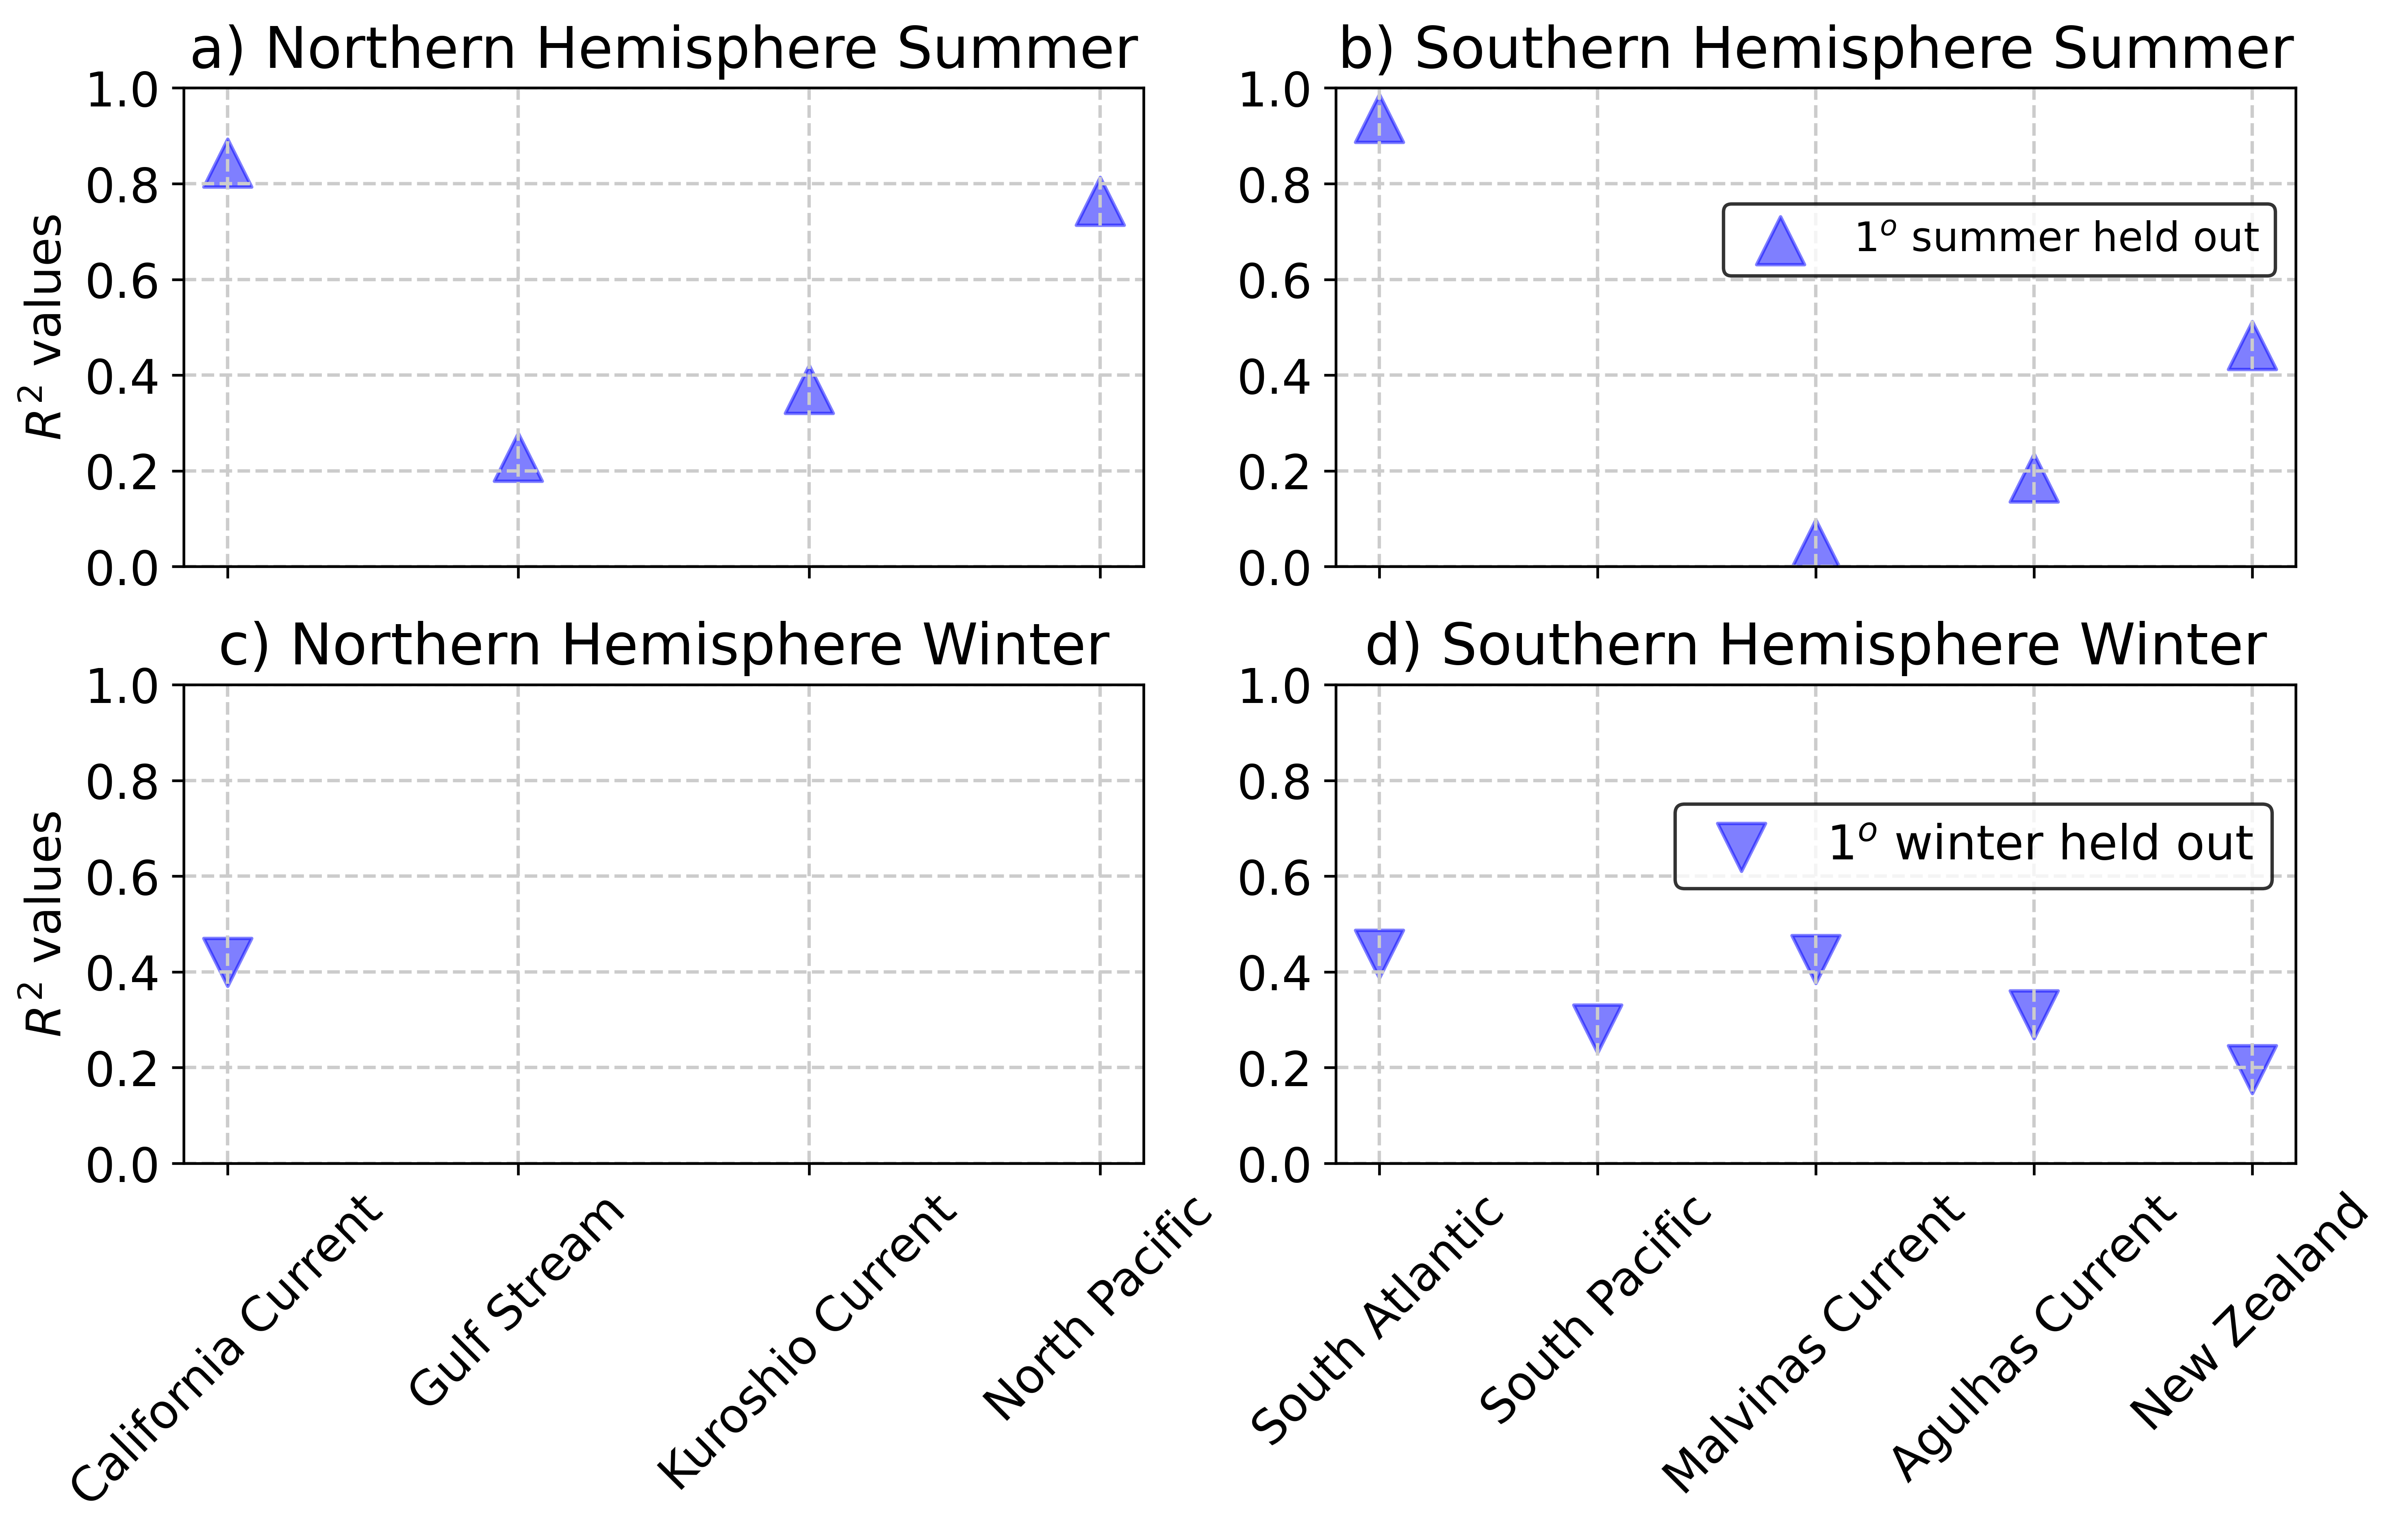

In [127]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8),dpi=600)
fig.tight_layout(pad=2.0)
plt.rcParams.update({'font.size': 14})

plt.subplot(3,2,1)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)


plt.scatter(range(12)[:4],r2_summer_loc[4,lat_ind_sorted][:4],s=200,marker='^',color='blue',alpha=0.5,label='$1^o$ summer held out')
plt.title('a) Northern Hemisphere Summer')
#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
plt.xticks(np.arange(len(label_list))[:4], [],rotation = 45, fontsize=14);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#/plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')



plt.subplot(3,2,2)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12)[7:],r2_summer_loc[4,lat_ind_sorted][7:],s=200,marker='^',color='blue',alpha=0.5,label='$1^o$ summer held out')
#plt.scatter(range(12),r2_winter_loc[4,lat_ind_sorted],s=200,marker='v',color='blue',alpha=0.5,label='1 winter held out')
#plt.scatter(range(12),r2_cnn_loc[4,lat_ind_sorted],s=200,c= 'blue',marker='*',alpha=0.5,label='$1^o$ CNN')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(np.arange(len(label_list))[7:], [],rotation = 45, fontsize=14);
#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=12,bbox_to_anchor=(1., 0.8),ncol=1).get_frame().set_edgecolor('k')
plt.title('b) Southern Hemisphere Summer')

plt.subplot(3,2,3)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12)[:4],r2_winter_loc[4,lat_ind_sorted][:4],s=200,marker='v',color='blue',alpha=0.5,label='$1^o$ winter held out')
#plt.scatter(range(12)[:4],r2_cnn_winter_loc[4,lat_ind_sorted[:4]],s=200,marker='o',color= 'blue', alpha=0.5,label='1 winter held out')

my_xticks = [label_list[i] for i in lat_ind_sorted[:4]] 
#plt.xticks([]);
plt.xticks(np.arange(len(label_list))[:4], my_xticks, rotation = 45, fontsize=14);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')
plt.title('c) Northern Hemisphere Winter')


plt.subplot(3,2,4)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12)[7:],r2_winter_loc[4,lat_ind_sorted][7:],s=200,marker='v',color='blue',alpha=0.5,label='$1^o$ winter held out')
#plt.scatter(range(12)[7:],r2_cnn_winter_loc[4,lat_ind_sorted[7:]],s=200,marker='o',color= 'blue', alpha=0.5,label='1 winter held out')
plt.title('d) Southern Hemisphere Winter')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted][7:]
plt.xticks(np.arange(len(label_list))[7:], my_xticks,rotation = 45, fontsize=14);

#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 0.8),ncol=1).get_frame().set_edgecolor('k')
#plt.savefig('./figures/r2_sensitivity_seasons_split',bbox_inches = 'tight')




In [72]:
i_loc=3
r2_winter_timeseries_loc[i_loc,~np.isnan(r2_winter_timeseries_loc[i_loc])].shape

(182,)

In [92]:
location_month_index_loc_winter

array([[1.14942760e-310, 4.68725703e-310, 4.68725480e-310, ...,
        1.03498055e+002, 1.03498055e+002, 1.03498055e+002],
       [9.00000000e+000, 9.00000000e+000, 9.00000000e+000, ...,
        1.03498055e+002, 1.03498055e+002, 1.03498055e+002],
       [1.03498055e+002, 1.03498055e+002, 1.03498055e+002, ...,
        1.03498055e+002, 1.03498055e+002, 1.03498055e+002],
       ...,
       [1.03498055e+002, 1.03498055e+002, 1.03498055e+002, ...,
        1.03498055e+002, 1.03498055e+002, 1.03498055e+002],
       [1.03498055e+002, 1.03498055e+002, 1.03498055e+002, ...,
        6.00000000e+000, 6.00000000e+000, 6.00000000e+000],
       [1.03498055e+002, 1.03498055e+002, 1.03498055e+002, ...,
        1.03498055e+002, 1.03498055e+002, 1.03498055e+002]])

In [85]:
location_month_index_loc_winter[i_loc,~np.isnan(location_month_index_loc_winter[i_loc])]

array([103.4980545, 103.4980545, 103.4980545, ..., 103.4980545,
       103.4980545, 103.4980545])

In [91]:
location_month_index_loc_winter[i_loc,submeso_dataset.location_ind[submeso_dataset.test_winter_ind]==i_loc]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])